# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
### 1. Pipeline Described 

My pipeline consisted of follow steps. 

1. Converts the images to grayscale or single channel using HLS color space and taking out S(saturation channel) .
2. Apply Gaussian Blur on the Single ch/Grayscales image.
3. Next use Canny edge detection on Blurred image.
4. Create Region of Interest (ROI) masking.
5. Extract line segment using 'Hough transform'.
6. Identify Line segment detected by 'Hough transform', based on +ve & -ve slope . And average slope and intercept per lane for each frame.
7. Further for Video processing, averaging of coordinates of each lane is done, over the number of frames, given by parameter `no_frame_avg`. To filter out noise and jitter
8. Finally image is overlay of the orignal image with the detected lanes and lane dimension extracted. 

Additional
1. While Identifing slope for video (challenge.mp4) with curved lane, slope and intercept change restriction is imposed, using flag parameter `slope_change_restriction`.
2. Three stages(Sigle channel, Blurred, Canny edges) of the pipeline are also overlayed on top part of the final output image, with Resized small image, to better observer the effect of parameter. 
3. Condition when no lanes are found in video is handled by providing average lanes over previous `no_frame_avg` frame, in which lanes were detected, with the below code calling appropriate functions
```
    if lines is not None:
        draw_lines(line_img, lines)
    else:  # in-case no lines are detected running average lane will be overlaid 
        draw_avg_lanes(line_img)
```
4. For averaging lanes over image frames `averging_over_frames = np.empty((0,7), int)` is initialized to empty before start of each video or individual picture processing. `averging_over_frames` stores coordinates of each lane over number of frames in number of row given by `no_frame_avg`. Data for frames older is removed by the code
```
if averging_over_frames.shape[0] > no_frame_avg:
            averging_over_frames = np.delete(averging_over_frames, 0, 0)
```
New frame's data is added by code
```averging_over_frames = np.vstack((averging_over_frames, np.array([lane_1_.......])))```

5. Function `draw_avg_lanes()` is used to draw lanes on blank image(along with other parameters such as frame size, length of lanes, number of frames averaged),  which is overlaid on original image with call to function `weighted_img()`

### 2. Identify potential shortcomings with your current pipeline

The pipeline does not consider dark lighting conditions, nor the curvature of the lanes,. 
Also it does not consider other objects (such as vehicle, people) that might obstruct the line of view.



### 3. Suggest possible improvements to your pipeline

Curved lane detection should be done by using perspective transform and other image correction techniques.
Parameter determination for various transforms used during detection should be dynamic, to cater for conditions 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


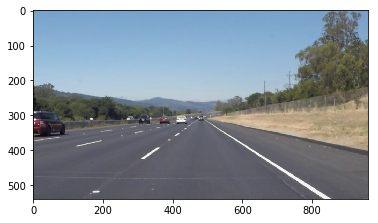

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: This function is used as a starting point to average/extrapolate the line segments detected 
    to map out the full extent of the lane.
    
    This function separats line segments by their slope ((y2-y1)/(x2-x1)) to decide which segments
    are part of the left line vs. the right line and over a threshold(to filter out near to horizontal lines.
    Then, average the position of each of the lines and extrapolate to the top and bottom of the lane.
    
    This function then adds detected lanes coordinated to Global paramenter 'averging_over_frames', 
    for calculating running average using next function  'draw_avg_lanes()'
    
    Additional for challenge Video, add slope restriction
    """
    global averging_over_frames
    lane1 = []
    lane2 = []

    # adding slope, intercept and detecting to which lane the line segment belongs to
    for line in lines:
        for x1, y1, x2, y2 in line:
#             slope = ((y1-y2)/(x1-x2))
#             intercept = ((x1*y2-x2*y1)/(x1-x2))
            slope, intercept = np.polyfit([x1,x2],[y1,y2],1)
            
            # additional slope change restriction code and conditons
            old_frame_data = averging_over_frames.shape[0]
            if slope_change_restriction=='y' and old_frame_data > 1:     
                lane_1_min_x, lane_1_min_y,lane_1_max_x, max_y,lane_2_min_x, lane_2_min_y,lane_2_max_x \
                = np.mean(averging_over_frames, 0, int)
                
                frame_avg_slope1, frame_avg_intercept1 = \
                np.polyfit([lane_1_min_x,lane_1_max_x],[lane_1_min_y,max_y],1)
                
                frame_avg_slope2, frame_avg_intercept2 = \
                np.polyfit([lane_2_min_x,lane_2_max_x],[lane_2_min_y,max_y],1)
                
            #condition to remove near horizontal,infinite, NaN slopes
            if (abs(slope) > 0.4) and (abs(slope) < 100) and (slope != float('NaN')):  
                if slope > 0 :
                    # additional slope change restriction code and conditons
                    if slope_change_restriction=='y' and old_frame_data > 1:
                        if abs((slope-frame_avg_slope1)) < 0.3 and abs((intercept-frame_avg_intercept1)) < 45:
                            lane1.append([slope, intercept, x1, y1, x2, y2])
                    else:
                        lane1.append([slope, intercept, x1, y1, x2, y2])
    
                else:
                    # additional slope change restriction code and conditons
                    if slope_change_restriction=='y' and old_frame_data > 1:
                        if abs((slope-frame_avg_slope2)) < 0.3 and abs((intercept-frame_avg_intercept2)) < 45:
                            lane2.append([slope, intercept, x1, y1, x2, y2])
                    else:
                        lane2.append([slope, intercept, x1, y1, x2, y2])

    if lane1!=[] and lane2!=[]:  # in-case no LANE lines are detected running average lane will be overlayed

        lane_1 = np.array(lane1)
        lane_2 = np.array(lane2)
        lane_1_slope_avg, lane_1_intercept_avg = np.mean(lane_1,0)[:2]
        lane_2_slope_avg, lane_2_intercept_avg = np.mean(lane_2,0)[:2]
        lane_1_min_y = int(np.min(lane_1[:,[3,5]]))
        lane_2_min_y = int(np.min(lane_2[:,[3,5]]))
        # top lane points
        lane_1_min_x = int((lane_1_min_y - lane_1_intercept_avg)/lane_1_slope_avg)
        lane_2_min_x = int((lane_2_min_y - lane_2_intercept_avg)/lane_2_slope_avg)

        # bottom lane points
        max_y = img.shape[0]
        lane_1_max_x = int((max_y - lane_1_intercept_avg)/lane_1_slope_avg)
        lane_2_max_x = int((max_y - lane_2_intercept_avg)/lane_2_slope_avg)
        
        # adding current frame lane to stack for averging and print later
        averging_over_frames = np.vstack((averging_over_frames, np.array([lane_1_min_x, lane_1_min_y, \
                                                                          lane_1_max_x, max_y, \
                                                                          lane_2_min_x, lane_2_min_y, \
                                                                          lane_2_max_x])))
        # removing old frames data
        if averging_over_frames.shape[0] > no_frame_avg:
            averging_over_frames = np.delete(averging_over_frames, 0, 0)
        
    draw_avg_lanes(img, color, thickness)

def draw_avg_lanes(img, color_lane=[255, 0, 0], thickness=10):
    """
    This function find the running average of coordinates of the lanes(or current values in-case of single frame), 
    and draws it on the image(along with lenght of lanes), which will be overlayed with orginal image/frame
    
    Global paramenter 'averging_over_frames' is used provides mean/average for all coordinate
    """
    global averging_over_frames
    if averging_over_frames.shape[0] > 0:     
        lane_1_min_x, lane_1_min_y,lane_1_max_x, max_y,lane_2_min_x, lane_2_min_y,lane_2_max_x \
        = np.mean(averging_over_frames, 0, int)
    
        cv2.line(img, (lane_1_min_x, lane_1_min_y), (lane_1_max_x, max_y), color_lane, thickness)
        cv2.line(img, (lane_2_min_x, lane_2_min_y), (lane_2_max_x, max_y), color_lane, thickness)
        
        #calculating length on lanes
        lane1_len = int(np.sqrt((lane_1_min_x - lane_1_max_x)**2 + (lane_1_min_y - max_y)**2))
        lane2_len = int(np.sqrt((lane_2_min_x - lane_2_max_x)**2 + (lane_2_min_y - max_y)**2))
       
        # Print additional text information on image
        cv2.putText(img, "'In Number of Pixels'", (int((img.shape[1])*0.75)+40, 50),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
        cv2.putText(img, "Image Size: {}X{}".format(img.shape[1],img.shape[0]), (int((img.shape[1])*0.75)+40, 70),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
        # Print current running average lane lengths on image in no. of pixel of image 
        cv2.putText(img, "Lane-R Lenght: {}".format(lane1_len), (int((img.shape[1])*0.75)+40, 90),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
        cv2.putText(img, "Lane-L Lenght: {}".format(lane2_len), (int((img.shape[1])*0.75)+40, 110),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
        cv2.putText(img, "no.frames avg: {}".format(averging_over_frames.shape[0]), (int((img.shape[1])*0.75)+40, 140),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)

    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#     from IPython import embed; embed()
    if lines is not None:
        draw_lines(line_img, lines)
    else:  # in-case no lines are detected running average lane will be overlayed 
        draw_avg_lanes(line_img)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines() (which further calls draw_lines(), draw_avg_lanes() )
    An image with lines drawn on it, blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing. initial_img and img must be the same shape!
    
    The result image is computed as follows:
    initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
files = os.listdir("test_images/")
files

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images

def lane_finding_pipline(image):
    imshape = image.shape
    #Gray-scale/single channel image
    if (imshape[0]>=720):  # exception for high resolution video, where Saturation channel indicates lanes clearly. e.g: in Challenge vidoe
        #extracting Saturation channel of the image 
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    else:
        img_gray = grayscale(image)
#     img_gray = grayscale(image)  

    # Gaussian Blur for filtering noise
    kernel_size = 5
    img_gaus = gaussian_blur(img_gray, kernel_size)

    # Canny Parameter determinatino
    low_threshold = 30
    high_threshold = 150

    # Apply Canny for edge detection
    img_canny = canny(img_gaus, low_threshold, high_threshold)


    # Creating a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(img_canny)   
    ignore_mask_color = 255   

    # defining a four sided polygon to mask to define ROI
    
    vertices = np.array([[ (imshape[1]*0.95, imshape[0]), (imshape[1]*0.07,imshape[0]), \
                (imshape[1]*0.4,imshape[0]*0.6),(imshape[1]*0.60, imshape[0]*0.6)]], dtype=np.int32)

    masked_edges = region_of_interest(img_canny, vertices)

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5  #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments

    # Run Hough on ROI of edge detected image, to  Draw lines
    # Output "lines" is an array containing endpoints of detected line segments
    # lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    lines_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Overlay recognised lane over the image
#     img_final = weighted_img(lines_edges, image)
    img_final1 = weighted_img(lines_edges, image)
    
    
    # Overlay pipline stages
    overlay_col_size = int(imshape[1]/4)
    overlay_row_size = int(imshape[0]/4)
    # resizing to fit smaller window
    img_gray_resized = cv2.resize(img_gray, (overlay_col_size, overlay_row_size ))
    img_gaus_resized = cv2.resize(img_gaus, (overlay_col_size, overlay_row_size ))
    img_canny_resized = cv2.resize(img_canny, (overlay_col_size, overlay_row_size ))
    
    # adding Single channel or Gray-scale to final output, with image label
    cv2.putText(img_final1, "Single ch/Gray-scale", (25, 20),\
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    img_final1[30:overlay_row_size + 30, 10:overlay_col_size +10 ]  \
    = cv2.cvtColor(img_gray_resized, cv2.COLOR_GRAY2RGB)           
    
    # adding Gaussian Blurred to final output, with image label
    cv2.putText(img_final1, "Gaussian Blurred", (overlay_col_size + 35, 20),\
                cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    img_final1[30:overlay_row_size + 30,  overlay_col_size + 20: 2*overlay_col_size +20 ]  \
    = cv2.cvtColor(img_gaus_resized, cv2.COLOR_GRAY2RGB)

    # adding Canny edge detected to final output, with image label
    cv2.putText(img_final1, "Canny edge detection", (2*overlay_col_size +45, 20),\
            cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 0), 1)
    img_final1[30:overlay_row_size + 30, 2*overlay_col_size +30: 3*overlay_col_size +30 ]  \
    = cv2.cvtColor(img_canny_resized, cv2.COLOR_GRAY2RGB)

    
    return img_final1

True

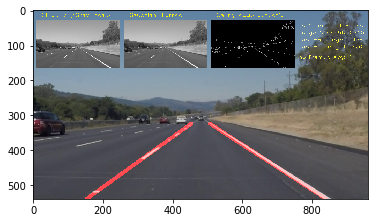

In [6]:
# select image
image_no = 1
image = mpimg.imread("test_images/"+files[image_no]) 

# invoke pipline
averging_over_frames =np.empty((0,7), int)
no_frame_avg = 1    # this is 1 for individual frame/image
slope_change_restriction='n'

img_final = lane_finding_pipline(image)
#display generated image
plt.imshow(img_final)

# then save them to the test_images_output directory.
# using time stamp for output filename to avoid overwriting old output files
import time
filename = time.strftime("%Y%m%d_%H%M%S") + files[image_no]

#ensure output folder 'test_images_output' is created in current directory before running the code
filepath = os.path.join("test_images_output/",filename)

# mpimg.imsave(filepath, img_final)
# prefered Open CV's image write function compared to matplotlib's save due to file consideration
cv2.imwrite(filepath, np.flip(img_final,2)) 


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # invoking pipeline here,
    # return the final output with lines drawn on lanes, along with the stages on the pipeline and pixel length on lanes
    result = lane_finding_pipline(image)
#     result = image

    return result

Run for Video with the solid white lane on the right first. Averaging running average lane coordinates over 20 frames

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
# averaging lanes over image frames
averging_over_frames = np.empty((0,7), int)  #queue to store lane coordintes for averaging over no. of frames(given by 'no_frame_avg')
no_frame_avg = 20  # this indicate the number on frames to average the lanes over
slope_change_restriction='n'

# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:11<00:00, 19.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 13.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
# averaging lanes over image frames
averging_over_frames = np.empty((0,7), int)  #queue to store lane coordintes for averaging over no. of frames(given by 'no_frame_avg')
no_frame_avg = 20  # this indicate the number on frames to average the lanes over
slope_change_restriction='n'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:25<00:00, 27.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 26.7 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
# averaging lanes over image frames
averging_over_frames = np.empty((0,7), int)  #queue to store lane coordintes for averaging over no. of frames(given by 'no_frame_avg')
no_frame_avg = 15  # this indicate the number on frames to average the lanes over
slope_change_restriction='y'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:27<00:00, 12.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 31 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))